In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

from src.preprocess_data import (
    create_df,
    process_train_df,
    get_id_to_elo_rating_dict,
)

In [2]:
df = create_df("../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
train = process_train_df(train)

In [3]:
ranked_ids = list(get_id_to_elo_rating_dict(train).keys())

In [4]:
num_players = len(set(train["p1_id"].values).union(set(train["p2_id"].values)))
num_games = len(train)

In [5]:
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    2 * np.std(raw_prior_score, ddof=1)
)

In [6]:
train_sorted = train.sort_values(
    ["abs_rank_diff", "p1_id"], ascending=[False, True]
)

### Set-up model and fit

In [7]:
ordered_model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecc2bf770adfa43c8f9294b9f3b8ce46 NOW.


In [8]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "player_1_rank": train_sorted["p1_prior_rank"].values.astype(int),
    "player_2_rank": train_sorted["p2_prior_rank"].values.astype(int),
    "player_1_white": train_sorted["p1_white"].values.astype(int),
    "b_mu": 0.0,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.25, 1.25]),
    "c_scale": 0.5,
    "w_mu": 5,
    "w_scale": 0.25,
    "fit_model": 1,
    "y": train_sorted["p1_outcome"].values,
}

In [9]:
fit = ordered_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
ordered_params = fit.extract(permuted=True)

ordered_inference_data = arviz.convert_to_inference_data(fit)
ordered_summary_df = (
    arviz.summary(ordered_inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [11]:
ordered_summary_df.head()

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,1.163,0.086,1.007,1.329,0.001,0.001,3638.0,3574.0,3681.0,2851.0,1.0
1,w,1.274,0.092,1.092,1.436,0.001,0.001,4578.0,4546.0,4643.0,3106.0,1.0
2,c[0],-0.708,0.073,-0.846,-0.572,0.001,0.001,4184.0,4184.0,4159.0,2921.0,1.0
3,c[1],2.025,0.084,1.874,2.187,0.001,0.001,3610.0,3607.0,3608.0,3412.0,1.0
4,sigma_a,0.175,0.087,0.000,0.311,0.003,0.002,725.0,725.0,702.0,690.0,1.0


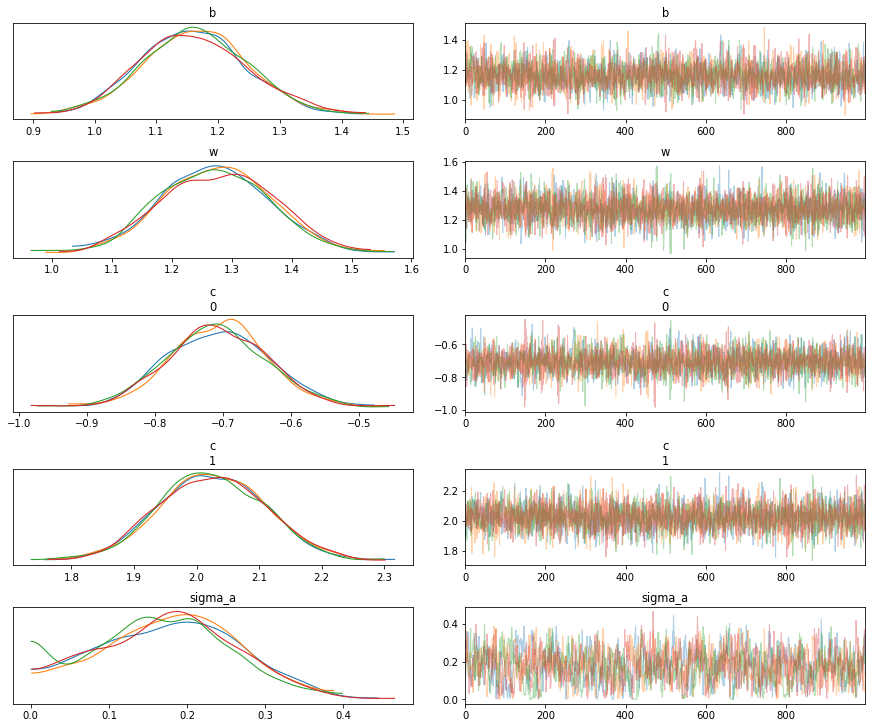

In [12]:
arviz.plot_trace(ordered_inference_data, var_names=["b", "w", "c", "sigma_a"]);

### Plotting

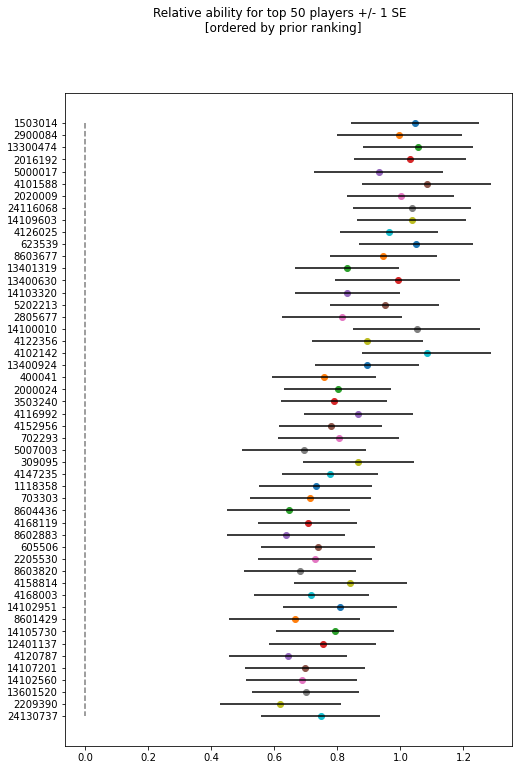

In [13]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 50

for i in range(plot_top_n_players):
    a_mean = ordered_params["a"][:, i].mean()
    a_sd = float(
        ordered_summary_df.loc[
            ordered_summary_df["parameter"] == f"a[{i}]", "sd"
        ]
    )
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)

plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.suptitle(
    f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]"
)
plt.yticks(range(1, plot_top_n_players + 1), ranked_ids[:plot_top_n_players]);

### Outcomes

In [14]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(ordered_params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out / np.mean(out.sum(1))

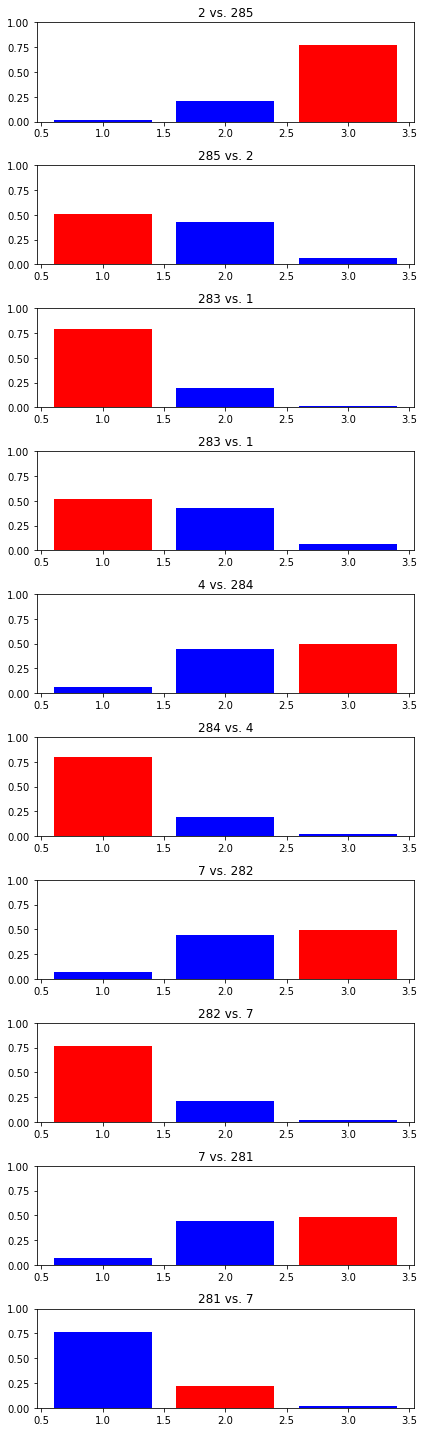

In [15]:
plot_n = 10
reverse = False
colors = ["blue"] * 3

plot_df = (
    train_sorted
    if not reverse
    else train_sorted.sort_values(
        ["abs_rank_diff", "p1_id"], ascending=[True, False]
    )
)
ranks = [
    f"{a} vs. {b}"
    for a, b in zip(
        train_sorted["p1_prior_rank"].values.astype(int),
        train_sorted["p2_prior_rank"].values.astype(int),
    )
]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[train_sorted["p1_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors)
    ax[i].set_title(f"{ranks[i]}")
    ax[i].set_ylim(0, 1)
plt.tight_layout();

In [16]:
cls_pred = np.argmax(out_prob, 1) + 1

In [17]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 0)

0.5494961470065205

In [18]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 1)

0.44101956135151155

In [19]:
np.mean(np.abs(train_sorted["p1_outcome"] - cls_pred) == 2)

0.00948429164196799